# **Automated ETF Reporting Pipeline**

This notebook implements the first steps of an automated ETF reporting pipeline, including environment setup, library installation, folder structure creation, and data ingestion preparation.
The goal is to simulate real financial analytics workflows.

# **STEP 1:** Importing principal packages & Creating Folder Structure

In [1]:
!pip install yfinance pyarrow scipy --quiet

In [2]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define project base directory
BASE = '/content/drive/MyDrive/automated-etf-reporting'

# Define subfolders
DATA_RAW = os.path.join(BASE, 'data/raw')
DATA_PARQ = os.path.join(BASE, 'data/parquet')
OUTPUT = os.path.join(BASE, 'output')
DOCS = os.path.join(BASE, 'docs')

# Create folders if they don't exist
for folder in [DATA_RAW, DATA_PARQ, OUTPUT, DOCS]:
    os.makedirs(folder, exist_ok=True)

print("Project folders created:")
print("BASE:", BASE)
print("RAW:", DATA_RAW)
print("PARQUET:", DATA_PARQ)
print("OUTPUT:", OUTPUT)
print("DOCS:", DOCS)


Project folders created:
BASE: /content/drive/MyDrive/automated-etf-reporting
RAW: /content/drive/MyDrive/automated-etf-reporting/data/raw
PARQUET: /content/drive/MyDrive/automated-etf-reporting/data/parquet
OUTPUT: /content/drive/MyDrive/automated-etf-reporting/output
DOCS: /content/drive/MyDrive/automated-etf-reporting/docs


# **STEP 2:** Project configuration & download ETF Prices.

In [5]:
etfs = ["VCN.TO", "XIC.TO", "BTCC-B.TO", "ETHH-B.TO"]
start_date = "2022-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(etfs, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)

[*********************100%***********************]  4 of 4 completed


In [6]:
csv_path = os.path.join(DATA_RAW, 'ETFs_close_prices_final.csv')
parquet_path = os.path.join(DATA_PARQ, 'ETFs_close_prices_final.parquet')


# Create a DataFrame of Close prices only
close_prices = pd.DataFrame({ticker: data[(ticker, 'Close')] for ticker in etfs})
close_prices.to_csv(csv_path, index=True)
close_prices.to_parquet(parquet_path, index=False)

close_prices.head()

,VCN.TO,XIC.TO,BTCC-B.TO,ETHH-B.TO
Date,,,,
2022-01-04,42.869999,33.770000,8.70,17.389999
2022-01-05,42.500000,33.470001,8.29,16.389999
2022-01-06,42.590000,33.520000,8.14,15.610000
2022-01-07,42.639999,33.529999,7.84,14.510000
2022-01-10,42.599998,33.509998,7.82,13.980000


In [7]:
# Create data mapping automatically
mapping = pd.DataFrame({
    "column": ["date"] + close_prices.columns.tolist(),
    "dtype": ["datetime"] + [str(close_prices[col].dtype) for col in close_prices.columns],
    "description": [
        "Date of closing price",
        "Closing price of VCN ETF (Canadian equity ETF)",
        "Closing price of XIC ETF (Canadian equity ETF)",
        "Closing price of BTCC Bitcoin ETF (crypto)",
        "Closing price of ETHH Ethereum ETF (crypto)"
    ]
})

# Save mapping into docs folder
mapping_path = os.path.join(DOCS, 'data_mapping_close_prices.xlsx')
mapping.to_excel(mapping_path, index=False)

mapping


,column,dtype,description
0,date,datetime,Date of closing price
1,VCN.TO,float64,Closing price of VCN ETF (Canadian equity ETF)
2,XIC.TO,float64,Closing price of XIC ETF (Canadian equity ETF)
3,BTCC-B.TO,float64,Closing price of BTCC Bitcoin ETF (crypto)
4,ETHH-B.TO,float64,Closing price of ETHH Ethereum ETF (crypto)


# **STEP 3:** Data Cleaning & Validation

In this section, we will validate, clean, and prepare the ETF time series dataset for financial analysis.
This includes:

Checking for missing values

Checking for duplicated dates

Ensuring index is datetime

Identifying outliers at the data level

Generating a small Data Quality Report

These validation steps follow financial data governance principles used in banking environments.

In [8]:
# Ensure index is datetime
close_prices.index = pd.to_datetime(close_prices.index)

# Sort by date to avoid ordering issues
close_prices = close_prices.sort_index()

close_prices.head()


,VCN.TO,XIC.TO,BTCC-B.TO,ETHH-B.TO
Date,,,,
2022-01-04,42.869999,33.770000,8.70,17.389999
2022-01-05,42.500000,33.470001,8.29,16.389999
2022-01-06,42.590000,33.520000,8.14,15.610000
2022-01-07,42.639999,33.529999,7.84,14.510000
2022-01-10,42.599998,33.509998,7.82,13.980000


In [9]:
#Data Shape & Basic Info
print("Rows:", close_prices.shape[0])
print("Columns:", close_prices.shape[1])
close_prices.info()


Rows: 975
Columns: 4
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 975 entries, 2022-01-04 to 2025-11-19
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   VCN.TO     975 non-null    float64
 1   XIC.TO     975 non-null    float64
 2   BTCC-B.TO  975 non-null    float64
 3   ETHH-B.TO  975 non-null    float64
dtypes: float64(4)
memory usage: 38.1 KB


In [10]:
#Check for Duplicated Dates
duplicates = close_prices.index.duplicated().sum()

print("Duplicated dates:", duplicates)

if duplicates > 0:
    close_prices = close_prices[~close_prices.index.duplicated()]
    print("Duplicates removed.")


Duplicated dates: 0


In [11]:
close_prices['VCN.TO'].isnull().sum()

np.int64(0)

In [12]:
#Check Missing Values Per ETF
null_report = pd.DataFrame({
    "ETF": close_prices.columns,
    "Missing Values": [close_prices[col].isnull().sum() for col in close_prices.columns]
})
null_report


,ETF,Missing Values
0,VCN.TO,0
1,XIC.TO,0
2,BTCC-B.TO,0
3,ETHH-B.TO,0


In [13]:
# Linearly Fill Missing Values. If NaN values exist, forward-fill prices
if close_prices.isnull().sum().sum() > 0:
    close_prices = close_prices.ffill()
    print("Missing prices forward-filled.")


In [14]:
#Validate Reasonable Price Ranges
range_report = {}

for col in close_prices.columns:
    min_val = close_prices[col].min()
    max_val = close_prices[col].max()
    range_report[col] = {
        "min": float(min_val),
        "max": float(max_val),
        "valid": min_val > 0
    }

pd.DataFrame(range_report).T

,min,max,valid
VCN.TO,36.77,62.869999,True
XIC.TO,28.959999,49.220001,True
BTCC-B.TO,3.09,24.549999,True
ETHH-B.TO,4.66,22.73,True


In [15]:
#Create Data Quality Report (excel)
dq_report = pd.DataFrame({
    "ETF": close_prices.columns,
    "Min Price": close_prices.min().values,
    "Max Price": close_prices.max().values,
    "Missing Values": close_prices.isnull().sum().values,
})

dq_path = os.path.join(DOCS, "data_quality_report.xlsx")
dq_report.to_excel(dq_path, index=False)

dq_report

,ETF,Min Price,Max Price,Missing Values
0,VCN.TO,36.770000,62.869999,0
1,XIC.TO,28.959999,49.220001,0
2,BTCC-B.TO,3.090000,24.549999,0
3,ETHH-B.TO,4.660000,22.730000,0


In [16]:
#Save Cleaned Dataset
clean_csv_path = os.path.join(DATA_RAW, "ETFs_close_prices_cleaned.csv")
clean_parquet_path = os.path.join(DATA_PARQ, "ETFs_close_prices_cleaned.parquet")

close_prices.to_csv(clean_csv_path)
close_prices.to_parquet(clean_parquet_path)

print("Clean dataset saved:")
print(clean_csv_path)
print(clean_parquet_path)


Clean dataset saved:
/content/drive/MyDrive/automated-etf-reporting/data/raw/ETFs_close_prices_cleaned.csv
/content/drive/MyDrive/automated-etf-reporting/data/parquet/ETFs_close_prices_cleaned.parquet


# **STEP 4:** Financial KPI Calculations

In this section, we compute key financial indicators for the ETF portfolio.

These KPIs are standard in asset management analytics and financial reporting workflows.

# Daily & Monthly Returns

In [17]:
# Calculate daily returns
daily_returns = close_prices.pct_change().dropna()
daily_returns.head()


,VCN.TO,XIC.TO,BTCC-B.TO,ETHH-B.TO
Date,,,,
2022-01-05,-0.008631,-0.008884,-0.047126,-0.057504
2022-01-06,0.002118,0.001494,-0.018094,-0.047590
2022-01-07,0.001174,0.000298,-0.036855,-0.070468
2022-01-10,-0.000938,-0.000596,-0.002551,-0.036527
2022-01-11,0.009155,0.010445,0.019182,0.044349


In [18]:
# Monthly returns using resample "Month End" & monthly compounding
monthly_returns = daily_returns.resample('ME').apply(lambda x: (1 + x).prod() - 1)
monthly_returns.head()


,VCN.TO,XIC.TO,BTCC-B.TO,ETHH-B.TO
Date,,,,
2022-01-31,-0.002799,-0.004738,-0.168965,-0.297297
2022-02-28,0.000702,0.002678,0.085754,0.049100
2022-03-31,0.032959,0.034421,0.071338,0.145866
2022-04-30,-0.050916,-0.050201,-0.139120,-0.131041
2022-05-31,0.001192,0.000302,-0.189227,-0.319232


# Annualized Volatility

Volatility helps investors understand the risk associated with an ETF or any investment. A higher volatility means a higher risk because the asset’s price is more unpredictable. Investors use volatility to make decisions about the amount of risk they are willing to take on. It can also help you build a diversified portfolio by balancing assets with different levels of volatility.

In [19]:
# Daily volatility per ETF
daily_vol = daily_returns.std()

# Annualized volatility = daily_vol * sqrt(252 trading days)
annualized_vol = daily_vol * np.sqrt(252)
annualized_vol


,0
VCN.TO,0.133157
XIC.TO,0.134276
BTCC-B.TO,0.521946
ETHH-B.TO,0.681588


# Cumulative Returns

Cumulative returns are calculated by compounding daily returns over the full time period.
This metric represents the total growth of a hypothetical investment and is essential for evaluating long-term performance, comparing ETFs, and understanding overall portfolio behavior.v

In [20]:
# Cumulative returns
cumulative_returns = (1 + daily_returns).cumprod() - 1
cumulative_returns.tail()


,VCN.TO,XIC.TO,BTCC-B.TO,ETHH-B.TO
Date,,,,
2025-11-13,0.439235,0.430264,1.212644,-0.135710
2025-11-14,0.444367,0.434705,1.128736,-0.146636
2025-11-17,0.432237,0.423453,1.073563,-0.179413
2025-11-18,0.430371,0.421972,1.088506,-0.149511
2025-11-19,0.441101,0.433225,1.024138,-0.196090


# Maximum Drawdown


Drawdown represents the percentage decline from the peak value of an investment over time. It measures both the depth and duration of losses. Overall, drawdown analysis helps investors understand not just how much they can gain, but also how much they might lose—making it an essential tool for building a well-balanced portfolio aligned with risk tolerance

In [21]:
def max_drawdown(series):
    """
    Maximum Drawdown:
    peak-to-trough drop during the time period.
    """
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

max_drawdowns = daily_returns.apply(max_drawdown)
max_drawdowns


,0
VCN.TO,-0.180339
XIC.TO,-0.179603
BTCC-B.TO,-0.651045
ETHH-B.TO,-0.715680


# KPI Summary Table

YTD Return represents the compounded performance of each ETF from the beginning of the current calendar year to the most recent available date. It is a key performance metric widely used in financial reporting and portfolio analysis.

In [22]:
kpi_summary = pd.DataFrame({
    "Annualized Volatility": annualized_vol,
    "Max Drawdown": max_drawdowns,
    "Total Cumulative Return": cumulative_returns.iloc[-1],
    "YTD Return": (1 + daily_returns.loc[daily_returns.index >= f"{pd.Timestamp.today().year}-01-01"]).prod() - 1
})

kpi_summary


,Annualized Volatility,Max Drawdown,Total Cumulative Return,YTD Return
VCN.TO,0.133157,-0.180339,0.441101,0.223124
XIC.TO,0.134276,-0.179603,0.433225,0.228115
BTCC-B.TO,0.521946,-0.651045,1.024138,-0.074132
ETHH-B.TO,0.681588,-0.715680,-0.196090,-0.152727


In [23]:
#Export KPI Summary to Excel/CSV
kpi_path_csv = os.path.join(OUTPUT, "kpi_summary.csv")
kpi_path_excel = os.path.join(OUTPUT, "kpi_summary.xlsx")

kpi_summary.to_csv(kpi_path_csv)
kpi_summary.to_excel(kpi_path_excel)

print("Saved KPI Summary:")
print(kpi_path_csv)
print(kpi_path_excel)

Saved KPI Summary:
/content/drive/MyDrive/automated-etf-reporting/output/kpi_summary.csv
/content/drive/MyDrive/automated-etf-reporting/output/kpi_summary.xlsx


# **STEP 5:** Anomaly Detection & Alerts

This section identifies abnormal price movements using statistical thresholds.
Anomalies help simulate risk indicators and governance controls commonly used in financial reporting.
We will:

Detect daily return outliers using z-scores

Flag extreme movements per ETF

Create an anomaly report (CSV)

Generate simple rule-based alerts

These checks are typical in data validation pipelines in banking environments.

# Compute z-score for daily returns

In [24]:
# Calculate z-scores for returns
z_scores = daily_returns.apply(lambda col: stats.zscore(col, nan_policy='omit'))
z_scores.tail()


,VCN.TO,XIC.TO,BTCC-B.TO,ETHH-B.TO
Date,,,,
2025-11-13,-2.268693,-2.258862,-1.047147,-1.659207
2025-11-14,0.376344,0.319392,-1.192385,-0.310937
2025-11-17,-1.050636,-0.975667,-0.827102,-0.911402
2025-11-18,-0.204368,-0.170982,0.180854,0.832780
2025-11-19,0.845824,0.888072,-0.976271,-1.292562


In [25]:
z_scores.describe()

,VCN.TO,XIC.TO,BTCC-B.TO,ETHH-B.TO
count,974.000000,974.000000,9.740000e+02,9.740000e+02
mean,0.000000,0.000000,1.641397e-17,-1.823775e-17
std,1.000514,1.000514,1.000514e+00,1.000514e+00
min,-5.578400,-5.565806,-5.866586e+00,-6.072539e+00
25%,-0.510493,-0.520795,-5.736032e-01,-5.378079e-01
50%,0.070099,0.054507,-3.842754e-02,2.605274e-04
75%,0.575965,0.596330,5.444396e-01,5.234518e-01
max,6.366343,6.274556,6.580034e+00,4.618554e+00


In [26]:
# (|z| > 3) per ETF
(z_scores.abs() > 3).sum()


,0
VCN.TO,11
XIC.TO,11
BTCC-B.TO,12
ETHH-B.TO,17


Z-score analysis shows several extreme daily movements (|z| > 3) across ETFs, particularly in crypto-linked assets (BTCC, ETHH), but also in equity ETFs during market stress. These anomalies are flagged for governance and further review.

# Identify anomalies using absolute z-score

In [27]:
# Threshold for anomalies
threshold = 3

anomalies = (z_scores.abs() > threshold)
anomalies.tail()


,VCN.TO,XIC.TO,BTCC-B.TO,ETHH-B.TO
Date,,,,
2025-11-13,False,False,False,False
2025-11-14,False,False,False,False
2025-11-17,False,False,False,False
2025-11-18,False,False,False,False
2025-11-19,False,False,False,False


# Extract actual anomaly rowsv

In [28]:
# Long-format anomaly report ()
anomaly_records = []

for etf in daily_returns.columns:
    etf_anoms = daily_returns[etf][z_scores[etf].abs() > threshold]
    for date, value in etf_anoms.items():
        anomaly_records.append([date, etf, value])

anomaly_df = pd.DataFrame(anomaly_records, columns=["date", "ticker", "daily_return"])
anomaly_df = anomaly_df.sort_values("date").reset_index(drop=True)

anomaly_df.head()


,date,ticker,daily_return
0,2022-01-21,ETHH-B.TO,-0.135154
1,2022-02-04,BTCC-B.TO,0.124173
2,2022-02-04,ETHH-B.TO,0.152007
3,2022-05-09,XIC.TO,-0.030699
4,2022-05-09,BTCC-B.TO,-0.130499


In [29]:
# Create Anomaly Summary Report
summary_records = []

for etf in daily_returns.columns:

    # Anomalies by ETF
    etf_anoms = anomaly_df[anomaly_df['ticker'] == etf]

    if etf_anoms.empty:
        summary_records.append([etf, 0, None, None, None])
        continue

    total = etf_anoms.shape[0]

    worst_drop = etf_anoms['daily_return'].min()
    worst_drop_date = etf_anoms.loc[
        etf_anoms['daily_return'].idxmin(), 'date'
    ]

    biggest_jump = etf_anoms['daily_return'].max()
    biggest_jump_date = etf_anoms.loc[
        etf_anoms['daily_return'].idxmax(), 'date'
    ]

    summary_records.append([
        etf,
        total,
        worst_drop,
        worst_drop_date,
        biggest_jump,
        biggest_jump_date
    ])

summary_df = pd.DataFrame(summary_records, columns=[
    "ETF",
    "# Anomalies",
    "Worst Drawdown Return",
    "Date of Worst Drop",
    "Largest Positive Return",
    "Date of Largest Jump"
])

summary_df

,ETF,# Anomalies,Worst Drawdown Return,Date of Worst Drop,Largest Positive Return,Date of Largest Jump
0,VCN.TO,11,-0.046358,2025-04-04,0.053784,2025-04-09
1,XIC.TO,11,-0.046649,2025-04-04,0.053452,2025-04-09
2,BTCC-B.TO,12,-0.191529,2022-06-13,0.217500,2023-03-13
3,ETHH-B.TO,17,-0.259894,2022-06-13,0.198903,2024-05-21


In [30]:
# Define file paths
summary_csv_path = os.path.join(OUTPUT, "anomaly_summary.csv")
summary_excel_path = os.path.join(OUTPUT, "anomaly_summary.xlsx")

# Save to CSV
summary_df.to_csv(summary_csv_path, index=False)

# Save to Excel
summary_df.to_excel(summary_excel_path, index=False)

print("Anomaly Summary Report saved in:")
print(summary_csv_path)
print(summary_excel_path)


Anomaly Summary Report saved in:
/content/drive/MyDrive/automated-etf-reporting/output/anomaly_summary.csv
/content/drive/MyDrive/automated-etf-reporting/output/anomaly_summary.xlsx


# Create Simple Alerts (text-based)

In [31]:
alerts = []

for etf in daily_returns.columns:
    count = anomaly_df[anomaly_df['ticker'] == etf].shape[0]
    if count > 0:
        alerts.append(f"⚠ {etf}: {count} anomalies detected.")
    else:
        alerts.append(f"✔ {etf}: No anomalies detected.")

alerts

['⚠ VCN.TO: 11 anomalies detected.',
 '⚠ XIC.TO: 11 anomalies detected.',
 '⚠ BTCC-B.TO: 12 anomalies detected.',
 '⚠ ETHH-B.TO: 17 anomalies detected.']

In [32]:
#Save alerts as a text file (for automation)
alerts_path = os.path.join(OUTPUT, "alerts.txt")

with open(alerts_path, "w") as f:
    for line in alerts:
        f.write(line + "\n")

alerts_path


'/content/drive/MyDrive/automated-etf-reporting/output/alerts.txt'

# **STEP 6:** Visualizations & Analysis

# VISUALIZATION 1 — Cumulative Returns Over Time

This chart shows the cumulative performance of each ETF since the beginning of the data period.
Cumulative returns help visualize long-term growth and compare total performance across assets.

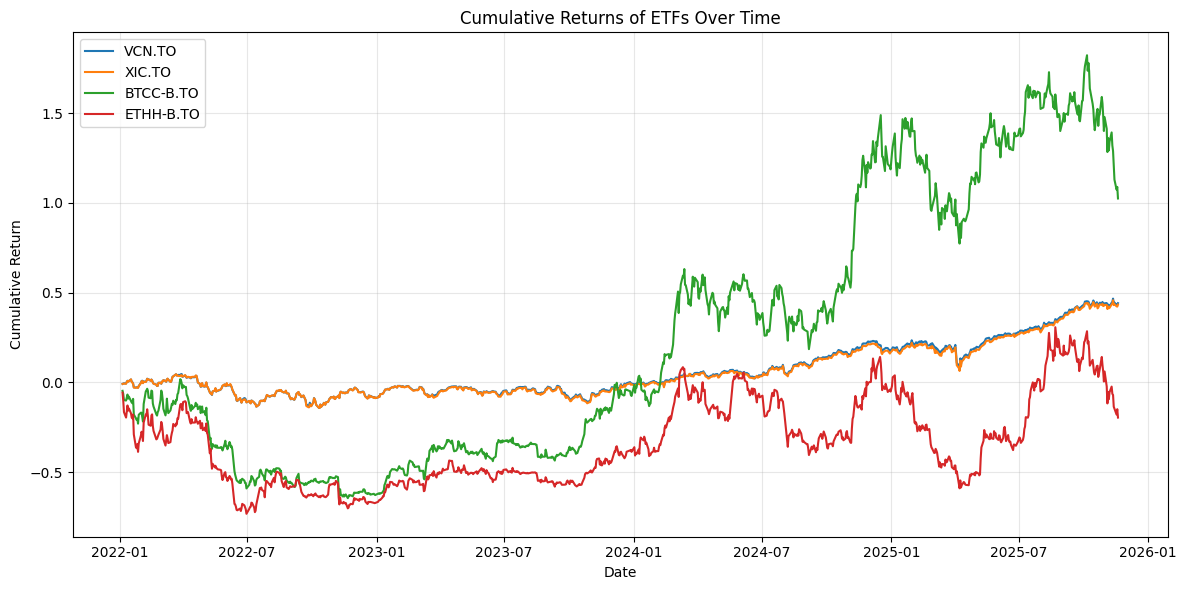

In [33]:
plt.figure(figsize=(12,6))

for etf in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[etf], label=etf)

plt.title("Cumulative Returns of ETFs Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**📌Análisis of Cumulative Returns Chart**

Equity ETFs (VCN.TO and XIC.TO) show stable and gradual long-term growth with limited volatility.
Crypto ETFs (BTCC-B.TO and ETHH-B.TO) display much larger swings, deep drawdowns in 2022, and strong rebounds starting in 2023.
BTCC-B.TO becomes the best performer overall, while ETHH-B.TO remains the most unstable.
This comparison illustrates the difference between traditional equity stability and crypto’s high-risk, high-reward behavior.v

# VISUALIZATION 2 — Rolling 30-Day Annualized Volatility

This chart shows how the risk of each ETF evolves over time by calculating a 30-day rolling annualized volatility.
The metric highlights periods of market stress, calm periods, and structural differences in volatility between equity and crypto assets.

In [34]:
rolling_vol_30d = daily_returns.rolling(30).std() * np.sqrt(252)

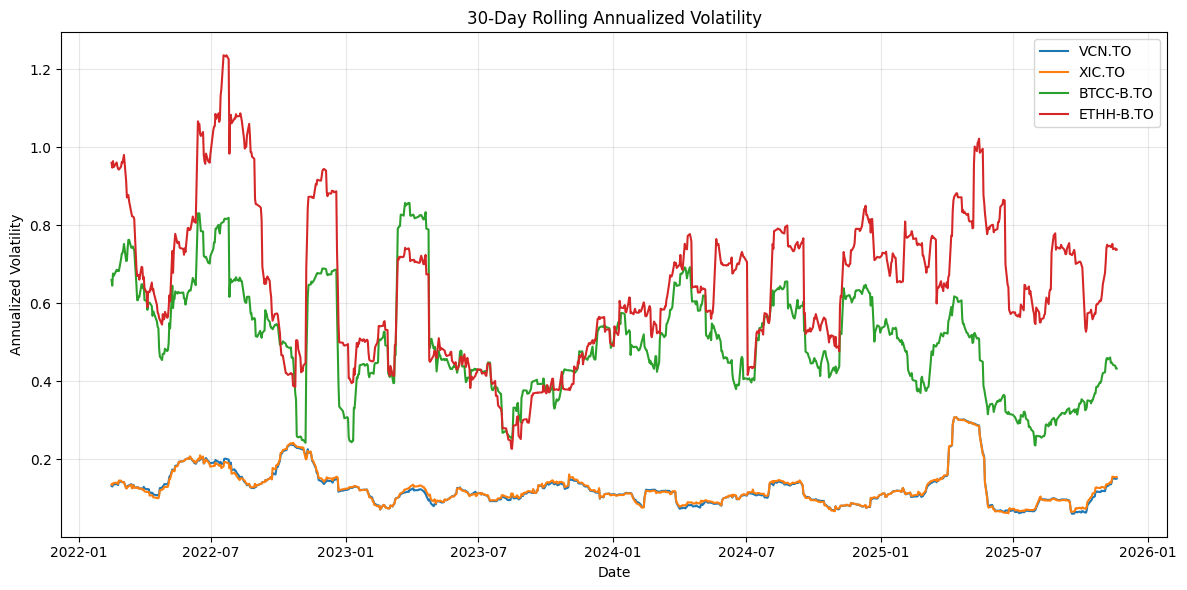

In [35]:
plt.figure(figsize=(12,6))

for etf in rolling_vol_30d.columns:
    plt.plot(rolling_vol_30d.index, rolling_vol_30d[etf], label=etf)

plt.title("30-Day Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**📌Analysis of the 30-Day Rolling Volatility Chart**

The rolling volatility clearly highlights structural differences between the ETFs.
Equity ETFs (VCN.TO and XIC.TO) show stable and relatively low volatility, remaining within a narrow risk band throughout the period.
In contrast, crypto-linked ETFs (BTCC-B.TO and ETHH-B.TO) exhibit significantly higher and more unstable volatility, with multiple sharp spikes that reflect periods of market stress or strong crypto price swings.
This confirms that crypto assets carry higher short-term risk compared to traditional equity ETFs.

# VISUALIZATION 3 — Drawdown Curve

Drawdown curves show how far each ETF has fallen from its previous peak at any point in time.
This is one of the most important risk visualizations, helping to understand depth, duration, and frequency of losses.
It highlights periods of stress, vulnerability to market corrections, and differences in risk profiles across assets.

In [36]:
# Calculate drawdown curves for each ETF
drawdown_curves = pd.DataFrame()

for etf in daily_returns.columns:
    cumulative = (1 + daily_returns[etf]).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    drawdown_curves[etf] = drawdown


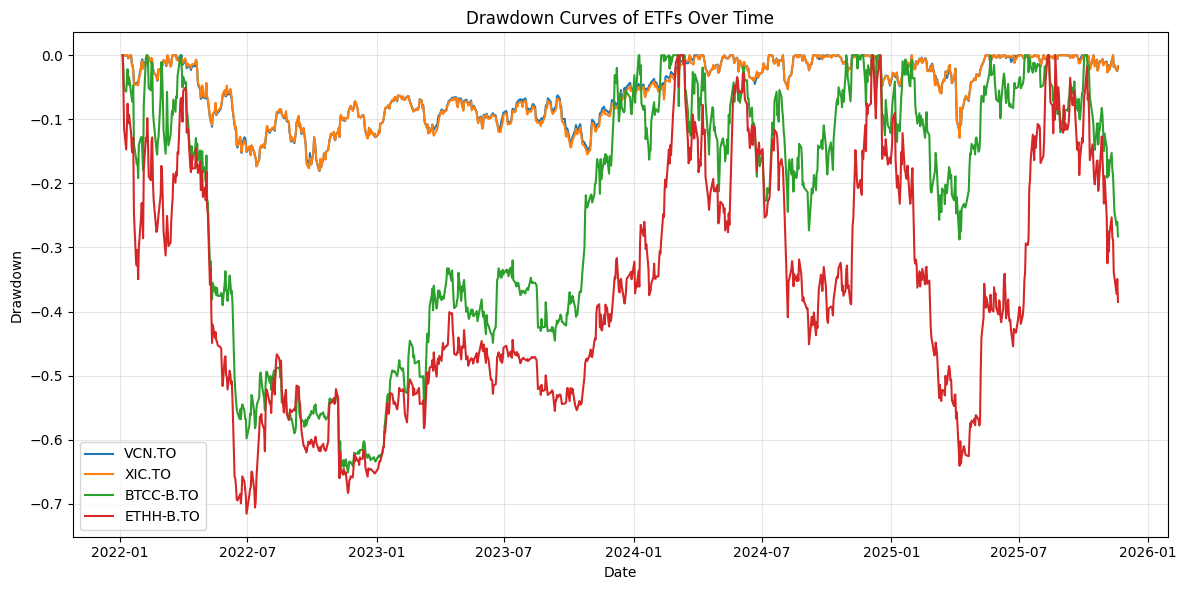

In [37]:
plt.figure(figsize=(12,6))

for etf in drawdown_curves.columns:
    plt.plot(drawdown_curves.index, drawdown_curves[etf], label=etf)

plt.title("Drawdown Curves of ETFs Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


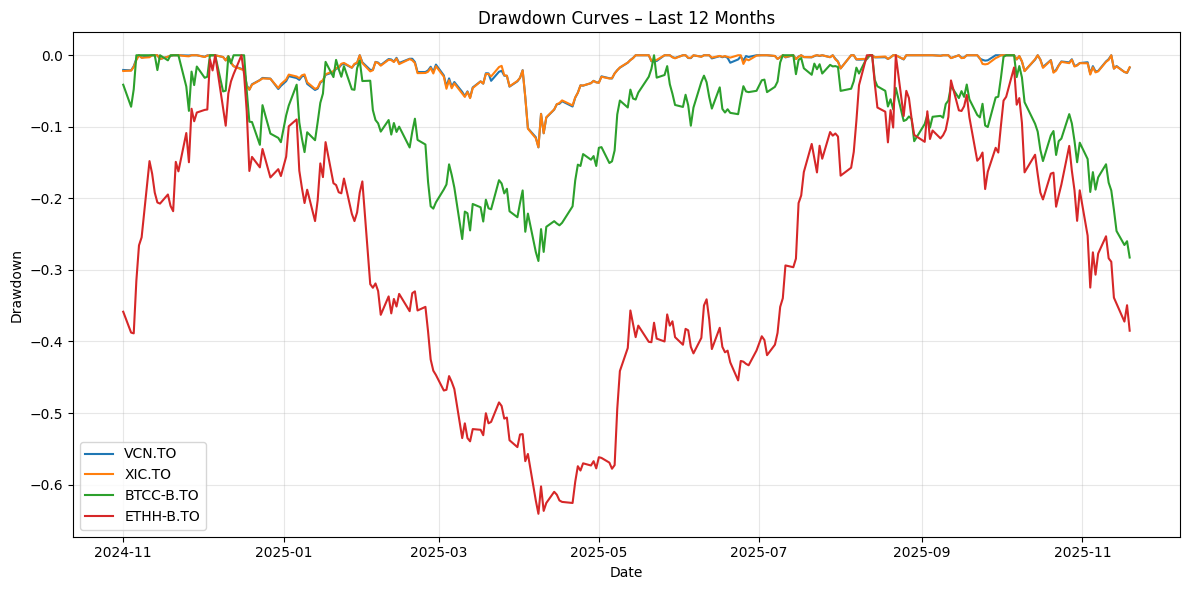

In [38]:
last_year = drawdown_curves.loc[drawdown_curves.index >= "2024-11-01"]

plt.figure(figsize=(12,6))
for etf in last_year.columns:
    plt.plot(last_year.index, last_year[etf], label=etf)

plt.title("Drawdown Curves – Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**📌 Analysis of Drawdowns (Last 12 Months)**

Focusing on the most recent 12 months provides a clearer view of current risk behavior.
Equity ETFs (VCN.TO and XIC.TO) show mild and short drawdowns, typically staying within the −3% to −10% range.
Crypto ETFs (BTCC-B.TO and ETHH-B.TO) continue to exhibit significantly deeper and more volatile drawdowns, with ETHH-B.TO showing the most unstable downside behavior.

This windowed view confirms that the risk gap between equity and crypto assets remains substantial in the most recent period.

# VISUALIZATION 4 — Anomaly Overlay Chart

This chart visualizes daily returns for each ETF with anomalies highlighted.
Placing the anomaly points directly on the return series helps identify extreme movements, volatility clusters, and risk events.
This is useful for data validation, governance, and understanding market shocks.

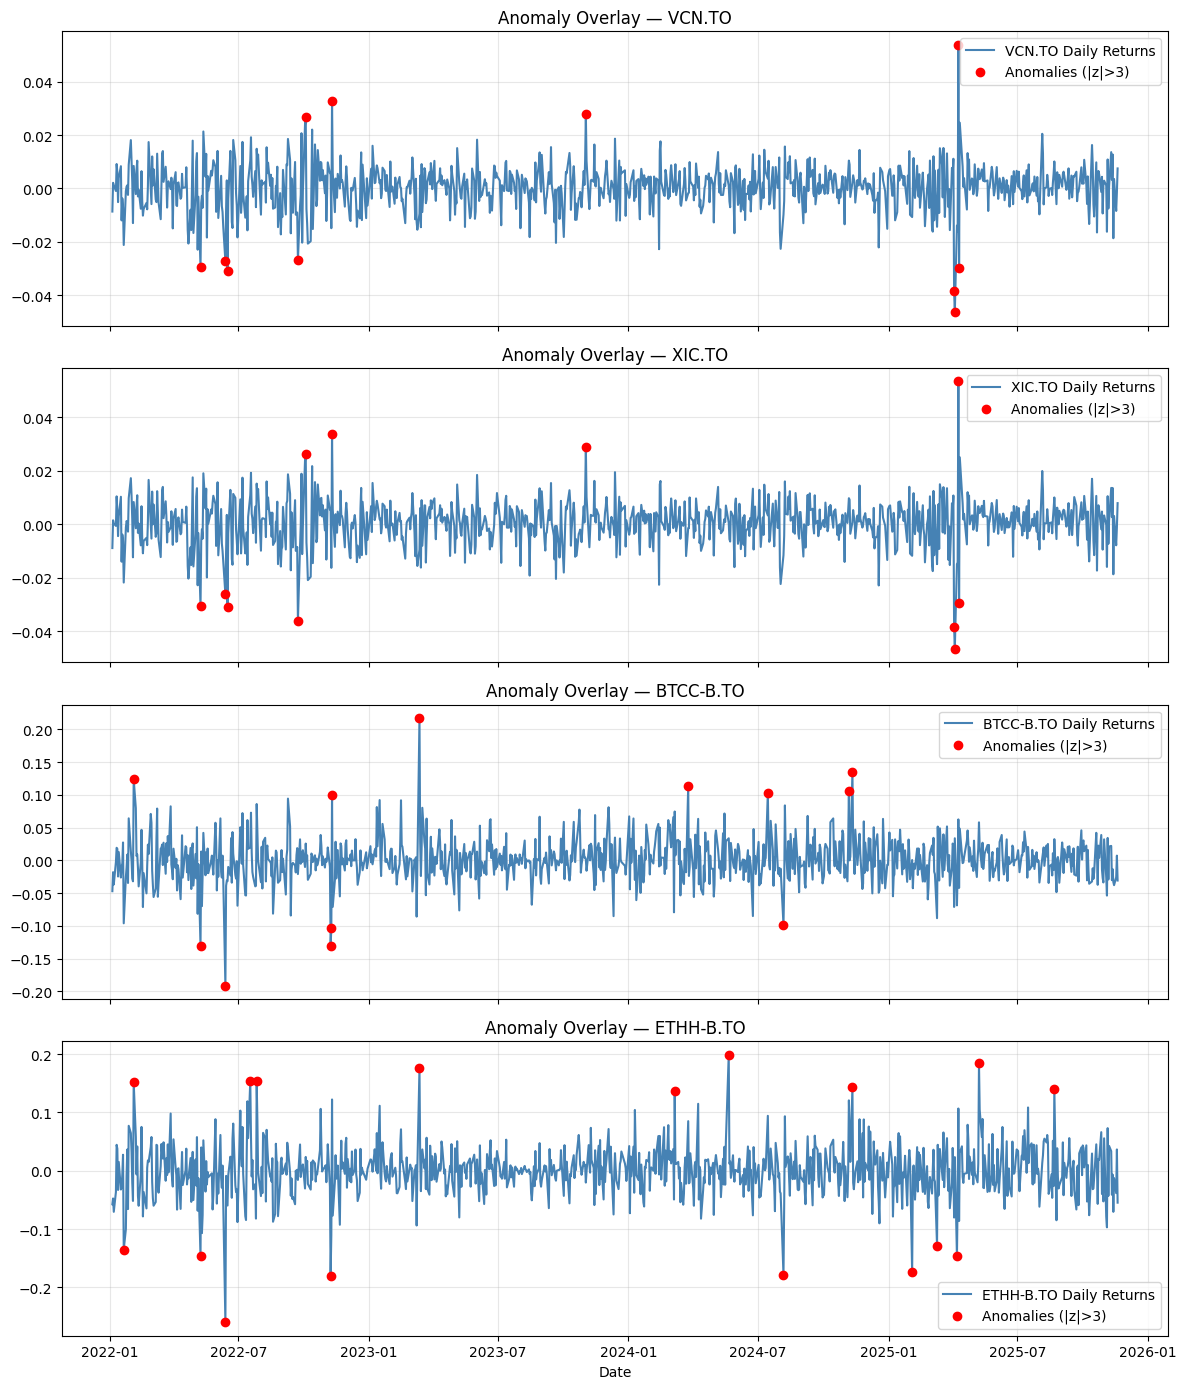

In [39]:
# Create subplots for all ETFs
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

etf_list = daily_returns.columns

for i, etf in enumerate(etf_list):

    # Daily returns
    axes[i].plot(
        daily_returns.index,
        daily_returns[etf],
        color="steelblue",
        label=f"{etf} Daily Returns"
    )

    # Anomalies for this ETF
    etf_anoms = anomaly_df[anomaly_df["ticker"] == etf]

    axes[i].scatter(
        etf_anoms["date"],
        etf_anoms["daily_return"],
        color="red",
        label="Anomalies (|z|>3)",
        zorder=5
    )

    axes[i].set_title(f"Anomaly Overlay — {etf}")
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


**📌 Analysis of Anomaly Overlay Subplots**

The four-panel anomaly chart provides a clear comparison of extreme daily movements across all ETFs.
Crypto ETFs (BTCC-B.TO and ETHH-B.TO) show a high density of anomalies, demonstrating strong volatility clustering and frequent extreme price swings.
On the other hand, equity ETFs (VCN.TO and XIC.TO) exhibit far fewer anomalies, with movements remaining mostly within normal statistical ranges.
This visualization highlights the fundamental risk differences between traditional equity assets and crypto-linked ETFs.

# VISUALIZATION 5 — Monthly Returns Heatmap

This heatmap shows the monthly returns for each ETF across years.
It highlights periods of strong performance, seasonal trends, market corrections, and volatility patterns.
It is a powerful tool for visualizing cycles and comparing behavior across ETFs.

In [40]:
def build_heatmap_table(etf):
    # Series of monthly returns ETF
    s = monthly_returns[etf].copy()

    df = s.to_frame(name="return")

    # (DatetimeIndex o PeriodIndex)
    df["Year"] = df.index.year
    df["Month"] = df.index.month  # 1-12

    heatmap_df = df.pivot(index="Year", columns="Month", values="return")

    # Order columns by Month
    heatmap_df = heatmap_df.sort_index(axis=1)

    return heatmap_df


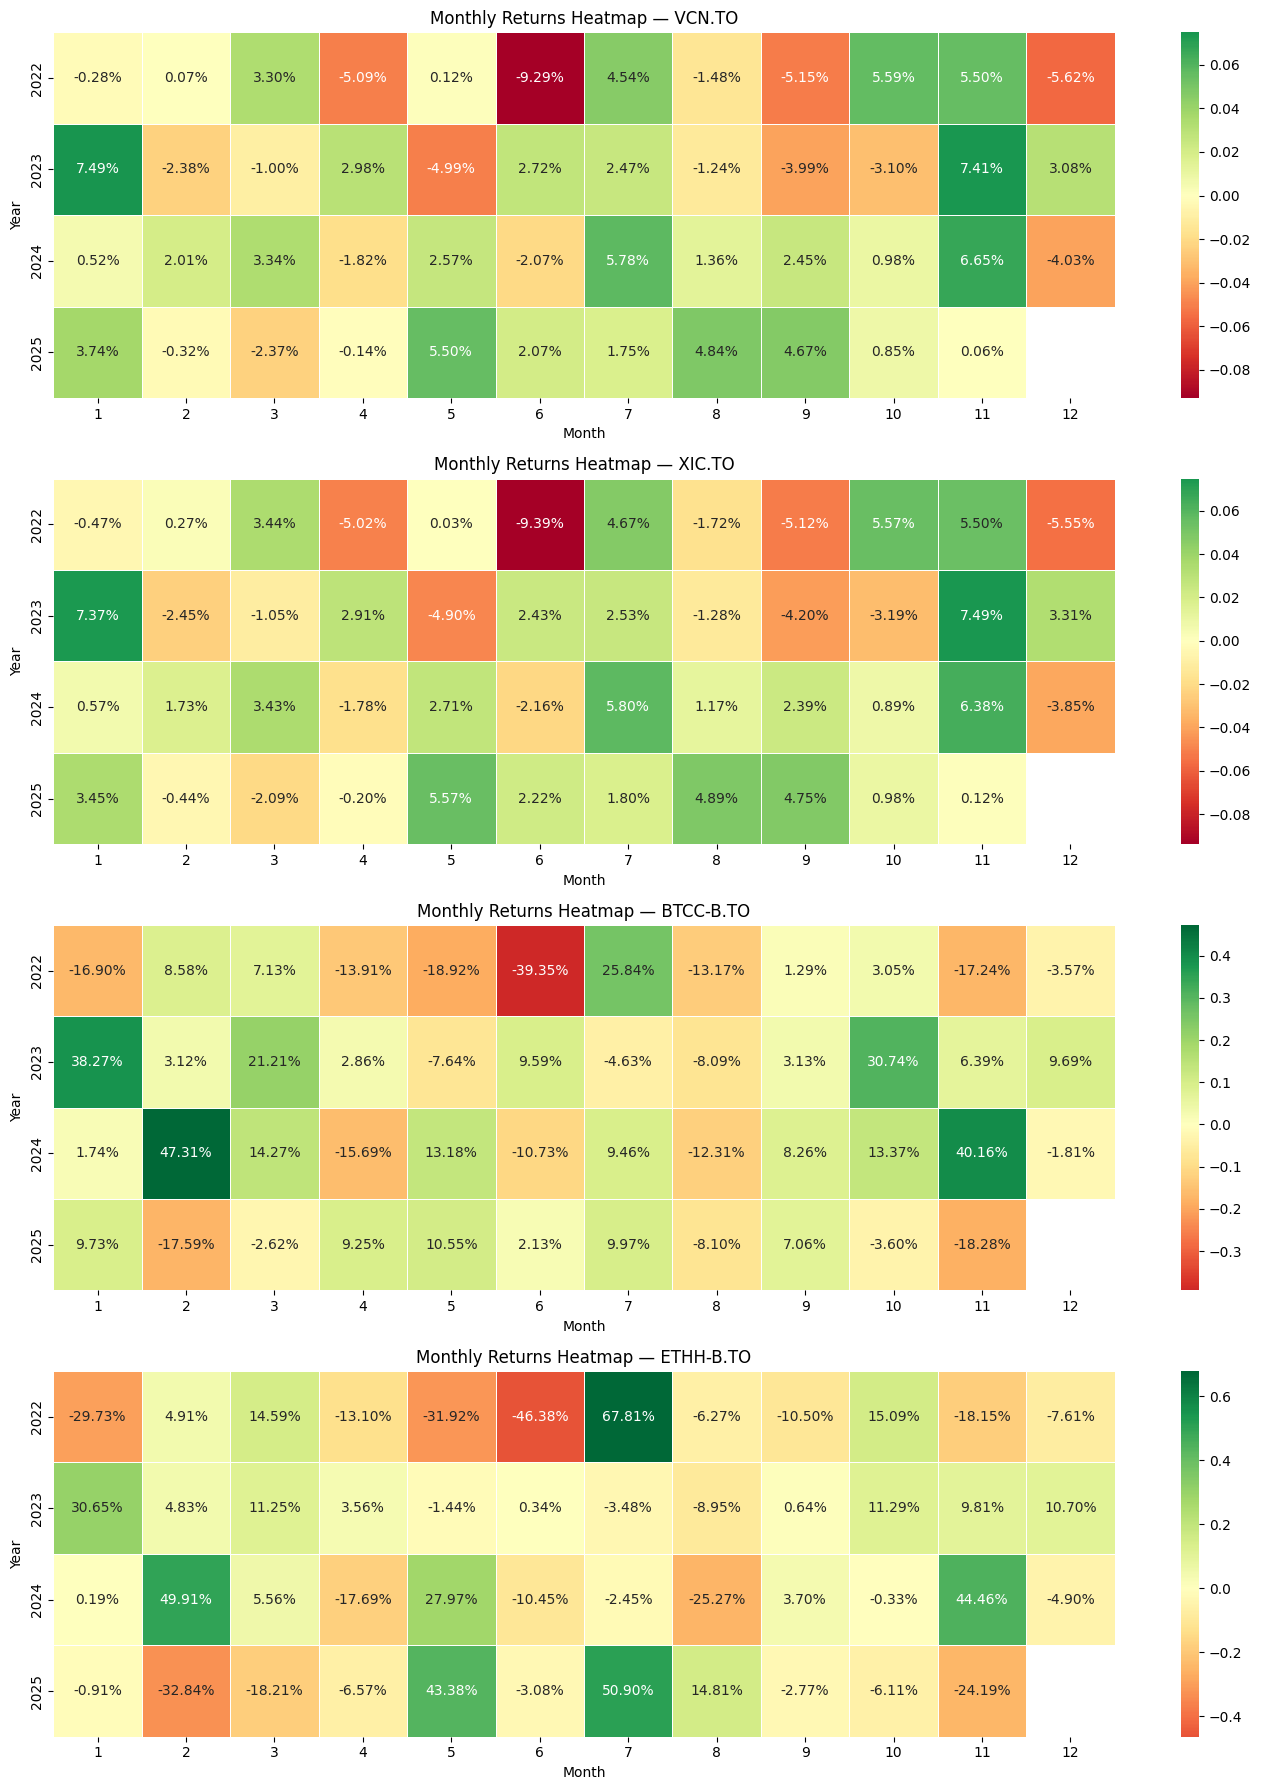

In [41]:
etf_list = monthly_returns.columns
fig, axes = plt.subplots(4, 1, figsize=(14, 18))

for i, etf in enumerate(etf_list):

    heatmap_df = build_heatmap_table(etf)

    sns.heatmap(
        heatmap_df,
        cmap="RdYlGn",
        center=0,
        annot=True,
        fmt=".2%",
        cbar=True,
        linewidths=0.5,
        ax=axes[i]
    )

    axes[i].set_title(f"Monthly Returns Heatmap — {etf}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Year")

plt.tight_layout()
plt.show()


**📌 Equity ETFs**

Stable, predictable monthly performance

Moderate returns

Lower risk

Limited number of extreme events

Consistent improvement over time

**📌 Crypto ETFs**

Extremely volatile

Large upside and downside swings

Pronounced negative months in 2022

Strong recovery cycles afterward

ETHH consistently more unstable than BTCC


Crypto offers much higher potential returns but carries significantly higher downside risk.
Equity delivers steady, stable growth with minimal volatility.

#**STEP 7:** Final Report & Executive Summary

In [42]:
# Folder for final report charts
REPORT_CHARTS = os.path.join(OUTPUT, "charts")
os.makedirs(REPORT_CHARTS, exist_ok=True)
REPORT_CHARTS

'/content/drive/MyDrive/automated-etf-reporting/output/charts'

In [43]:
# ================================================================
# 1. CUMULATIVE RETURNS CHART
# ================================================================
plt.figure(figsize=(12,6))
for etf in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[etf], label=etf)

plt.title("Cumulative Returns of ETFs Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)

cum_path = os.path.join(REPORT_CHARTS, "cumulative_returns.png")
plt.savefig(cum_path, dpi=300, bbox_inches='tight')
plt.close()


# ================================================================
# 2. ROLLING 30-DAY VOLATILITY
# ================================================================
plt.figure(figsize=(12,6))
for etf in rolling_vol_30d.columns:
    plt.plot(rolling_vol_30d.index, rolling_vol_30d[etf], label=etf)

plt.title("30-Day Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid(True, alpha=0.3)

vol_path = os.path.join(REPORT_CHARTS, "rolling_volatility_30d.png")
plt.savefig(vol_path, dpi=300, bbox_inches='tight')
plt.close()


# ================================================================
# 3. DRAWDOWN CURVES
# ================================================================
plt.figure(figsize=(12,6))
for etf in drawdown_curves.columns:
    plt.plot(drawdown_curves.index, drawdown_curves[etf], label=etf)

plt.title("Drawdown Curves of ETFs Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True, alpha=0.3)

dd_path = os.path.join(REPORT_CHARTS, "drawdown_curves.png")
plt.savefig(dd_path, dpi=300, bbox_inches='tight')
plt.close()


# ================================================================
# 4. ANOMALY OVERLAY — 4 SUBPLOTS
# ================================================================
fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True)
etf_list = daily_returns.columns

for i, etf in enumerate(etf_list):

    axes[i].plot(daily_returns.index, daily_returns[etf], color="steelblue", label=f"{etf} Daily Returns")
    etf_anoms = anomaly_df[anomaly_df['ticker'] == etf]

    axes[i].scatter(
        etf_anoms["date"],
        etf_anoms["daily_return"],
        color="red",
        label="Anomalies (|z|>3)",
        zorder=5
    )

    axes[i].set_title(f"Anomaly Overlay — {etf}")
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.xlabel("Date")
plt.tight_layout()

anom_overlay_path = os.path.join(REPORT_CHARTS, "anomaly_overlay_subplots.png")
plt.savefig(anom_overlay_path, dpi=300, bbox_inches='tight')
plt.close()


# ================================================================
# 5. MONTHLY RETURNS HEATMAPS — 4 SUBPLOTS
# ================================================================

def build_heatmap_table(etf):
    s = monthly_returns[etf].copy()
    df = s.to_frame(name="return")
    df["Year"] = df.index.year
    df["Month"] = df.index.month
    heatmap_df = df.pivot(index="Year", columns="Month", values="return")
    heatmap_df = heatmap_df.sort_index(axis=1)
    return heatmap_df

fig, axes = plt.subplots(4, 1, figsize=(14, 18))

for i, etf in enumerate(etf_list):
    heatmap_df = build_heatmap_table(etf)

    sns.heatmap(
        heatmap_df,
        cmap="RdYlGn",
        center=0,
        annot=True,
        fmt=".2%",
        cbar=True,
        linewidths=0.5,
        ax=axes[i]
    )

    axes[i].set_title(f"Monthly Returns Heatmap — {etf}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Year")

plt.tight_layout()

heatmap_path = os.path.join(REPORT_CHARTS, "monthly_returns_heatmaps.png")
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
plt.close()


# ================================================================
# OUTPUT
# ================================================================
print("All charts saved to:", REPORT_CHARTS)


All charts saved to: /content/drive/MyDrive/automated-etf-reporting/output/charts


In [44]:
!pip install xlsxwriter --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 6.5 MB/s eta 0:00:00


In [45]:
# ================================================================
# FINAL REPORT (EXCEL) — KPI SUMMARY + ANOMALY SUMMARY
# ================================================================

master_report_path = os.path.join(OUTPUT, "ETF_Final_Report.xlsx")

with pd.ExcelWriter(master_report_path, engine='xlsxwriter') as writer:

    # KPI Summary
    kpi_summary.to_excel(writer, sheet_name="KPI Summary")

    # Anomaly Summary
    summary_df.to_excel(writer, sheet_name="Anomaly Summary", index=False)

    # Metadata Sheet
    metadata = {
        "Generated On": [pd.Timestamp.today()],
        "ETFs Included": [", ".join(daily_returns.columns)],
        "Frequency": ["Daily data, monthly and custom aggregates"],
        "Contains": ["KPIs, volatility, drawdowns, anomalies, heatmaps"]
    }
    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_excel(writer, sheet_name="Metadata", index=False)

master_report_path


'/content/drive/MyDrive/automated-etf-reporting/output/ETF_Final_Report.xlsx'

# Executive Summary – Automated ETF Reporting Pipeline

This automated analytics pipeline processes ETF data, computes key financial metrics, detects anomalies, and generates a complete reporting package.
The analysis highlights clear differences between traditional Canadian equity ETFs (VCN.TO, XIC.TO) and crypto-linked ETFs (BTCC-B.TO, ETHH-B.TO).

**Key Findings**

Equity ETFs demonstrate low volatility, stable monthly performance, and shallow drawdowns.

Crypto ETFs show extremely high volatility, deep drawdowns (up to −70%), and strong rebound cycles.

BTCC-B.TO shows the strongest long-term recovery and periods of exceptional monthly gains.

ETHH-B.TO remains the most unstable asset, with repeated deep declines and slower recoveries.

Rolling volatility confirms the structural risk differences between crypto and equity assets.

Anomaly detection identifies multiple extreme events in crypto assets, while equity ETFs show very few anomalies.

**Deliverables Generated Automatically**

KPI Summary (Volatility, Drawdown, Returns)

Anomaly Summary (counts, worst drops, dates)

Cumulative Returns chart

Rolling Volatility chart

Drawdown Curves

Monthly Returns Heatmaps

Anomaly Overlay charts

Final Excel Report with multiple tabs

Visualization set exported in /output/charts

This project demonstrates capabilities in automation, quantitative analysis, anomaly detection, financial reporting, and data governance—skills aligned with analytics roles in financial institutions.

# **STEP 8:** main.py – Automated ETF Reporting Pipelinev

In [46]:
%%writefile config.yaml
etfs:
  - VCN.TO
  - XIC.TO
  - BTCC-B.TO
  - ETHH-B.TO

start_date: "2022-01-01"
end_date: "today"

paths:
  raw: "data/raw"
  clean: "data/clean"
  output: "output"
  charts: "output/charts"
  reports: "output/final_report"

Writing config.yaml


In [47]:
!mkdir -p data/raw
!mkdir -p data/clean
!mkdir -p output
!mkdir -p output/charts
!mkdir -p output/final_report
!mkdir -p src

In [48]:
%%writefile src/data_ingestion.py
import yfinance as yf
import pandas as pd

def download_etf_data(etfs, start_date, end_date):
    """
    Downloads historical price data for a list of ETFs.
    Returns a DataFrame with multi-level columns: [Ticker → OHLCV].
    """

    try:
        data = yf.download(
            etfs,
            start=start_date,
            end=end_date,
            group_by='ticker',
            auto_adjust=False,
            progress=False
        )
        print("✔ Data successfully downloaded.")
        return data

    except Exception as e:
        print("❌ Error downloading ETF data:", e)
        return pd.DataFrame()


Writing src/data_ingestion.py


In [49]:
%%writefile src/data_cleaning.py
import pandas as pd
import numpy as np
import os

def clean_data(df_raw, paths):
    """
    Cleans the downloaded ETF dataset and prepares:
    - clean close price table
    - daily returns
    - monthly returns
    """

    # Extract list of tickers from MultiIndex columns
    tickers = sorted({col[0] for col in df_raw.columns})

    # Build a clean Close prices DataFrame
    close_df = pd.DataFrame()

    for ticker in tickers:
        # Extract Close column for this ticker
        close_df[ticker] = df_raw[(ticker, "Close")]

    # Drop rows with missing values
    close_df = close_df.dropna()

    # Save cleaned data
    clean_path = os.path.join(paths["clean"], "etf_clean_close.csv")
    close_df.to_csv(clean_path)

    # Calculate daily returns
    daily_returns = close_df.pct_change().dropna()

    # Save daily returns
    daily_path = os.path.join(paths["clean"], "etf_daily_returns.csv")
    daily_returns.to_csv(daily_path)

    # Monthly returns using compounded formula
    monthly_returns = daily_returns.resample("ME").apply(lambda x: (1 + x).prod() - 1)

    # Save monthly data
    monthly_path = os.path.join(paths["clean"], "etf_monthly_returns.csv")
    monthly_returns.to_csv(monthly_path)

    print("✔ Data cleaned successfully.")

    return close_df, daily_returns, monthly_returns


Writing src/data_cleaning.py


In [50]:
%%writefile src/kpi_calculations.py
import pandas as pd
import numpy as np


def max_drawdown(series):
    """
    Computes maximum drawdown for a return series.
    Drawdown = (cumulative - peak) / peak
    """
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()


def calculate_kpis(close_df, daily_returns):
    """
    Computes all core KPIs:
    - cumulative returns
    - daily volatility
    - annualized volatility
    - maximum drawdown
    - rolling 30-day volatility
    - KPI summary table
    """

    # --------------------------------------------------------
    # 1. Cumulative Returns
    # --------------------------------------------------------
    cumulative_returns = (1 + daily_returns).cumprod() - 1

    # --------------------------------------------------------
    # 2. Volatility
    # --------------------------------------------------------
    daily_vol = daily_returns.std()
    annual_vol = daily_vol * np.sqrt(252)

    # --------------------------------------------------------
    # 3. Maximum Drawdown
    # --------------------------------------------------------
    drawdowns = daily_returns.apply(max_drawdown)

    # --------------------------------------------------------
    # 4. Rolling 30-Day Annualized Volatility
    # --------------------------------------------------------
    rolling_vol_30d = daily_returns.rolling(30).std() * np.sqrt(252)

    # --------------------------------------------------------
    # 5. YTD Return
    # --------------------------------------------------------
    current_year = pd.Timestamp.today().year
    ytd_mask = daily_returns.index >= f"{current_year}-01-01"

    ytd_returns = (1 + daily_returns[ytd_mask]).prod() - 1

    # --------------------------------------------------------
    # 6. Build KPI Summary DataFrame
    # --------------------------------------------------------
    kpi_summary = pd.DataFrame({
        "Annualized Volatility": annual_vol,
        "Maximum Drawdown": drawdowns,
        "YTD Return": ytd_returns
    })

    kpi_summary.index.name = "ETF"

    print("✔ KPIs calculated successfully.")

    return kpi_summary, cumulative_returns, rolling_vol_30d


Writing src/kpi_calculations.py


In [51]:
%%writefile src/anomaly_detection.py
import pandas as pd
import numpy as np
from scipy import stats


def detect_anomalies(daily_returns, threshold=3):
    """
    Detects anomalies using z-scores.
    Returns:
    - anomaly_df: full list of anomalies
    - summary_df: summarized metrics per ETF
    """

    # --------------------------------------------------------
    # 1. Compute z-scores for each ETF
    # --------------------------------------------------------
    z_scores = daily_returns.apply(
        lambda col: stats.zscore(col, nan_policy='omit')
    )

    # --------------------------------------------------------
    # 2. Build dataframe of anomalies
    # --------------------------------------------------------
    anomaly_records = []

    for etf in daily_returns.columns:
        # Mask where absolute z-score > threshold
        mask = z_scores[etf].abs() > threshold
        etf_anoms = daily_returns[etf][mask]

        # Record anomalies
        for date, value in etf_anoms.items():
            anomaly_records.append([date, etf, value])

    anomaly_df = pd.DataFrame(
        anomaly_records,
        columns=["date", "ticker", "daily_return"]
    ).sort_values("date").reset_index(drop=True)

    # --------------------------------------------------------
    # 3. Build anomaly summary by ETF
    # --------------------------------------------------------
    summary_records = []

    for etf in daily_returns.columns:
        etf_rows = anomaly_df[anomaly_df['ticker'] == etf]

        if etf_rows.empty:
            summary_records.append([etf, 0, None, None, None, None])
            continue

        total = etf_rows.shape[0]
        worst_drop = etf_rows['daily_return'].min()
        worst_drop_date = etf_rows.loc[
            etf_rows['daily_return'].idxmin(), 'date'
        ]

        biggest_jump = etf_rows['daily_return'].max()
        biggest_jump_date = etf_rows.loc[
            etf_rows['daily_return'].idxmax(), 'date'
        ]

        summary_records.append([
            etf,
            total,
            worst_drop,
            worst_drop_date,
            biggest_jump,
            biggest_jump_date
        ])

    summary_df = pd.DataFrame(
        summary_records,
        columns=[
            "ETF",
            "# Anomalies",
            "Worst Drawdown Return",
            "Date of Worst Drop",
            "Largest Positive Return",
            "Date of Largest Jump"
        ]
    )

    print(f"✔ Anomaly detection completed. Total anomalies: {len(anomaly_df)}")

    return anomaly_df, summary_df

Writing src/anomaly_detection.py


In [52]:
%%writefile src/reporting.py
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================================================================
# UTILS
# ================================================================
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


# ================================================================
# 1. SAVE KPI REPORT
# ================================================================
def save_kpi_report(kpi_summary, paths):
    report_path = os.path.join(paths["reports"], "KPI_Summary.xlsx")
    ensure_dir(paths["reports"])
    kpi_summary.to_excel(report_path)
    print(f"✔ KPI report saved: {report_path}")


# ================================================================
# 2. SAVE ANOMALY REPORT
# ================================================================
def save_anomaly_report(anomaly_summary, paths):
    report_path = os.path.join(paths["reports"], "Anomaly_Summary.xlsx")
    ensure_dir(paths["reports"])
    anomaly_summary.to_excel(report_path, index=False)
    print(f"✔ Anomaly summary saved: {report_path}")


# ================================================================
# 3. BUILD HEATMAP DATAFRAME
# ================================================================
def build_heatmap_table(monthly_returns, etf):
    s = monthly_returns[etf].copy()
    df = s.to_frame(name="return")
    df["Year"] = df.index.year
    df["Month"] = df.index.month
    heatmap_df = df.pivot(index="Year", columns="Month", values="return")
    return heatmap_df.sort_index(axis=1)


# ================================================================
# 4. SAVE ALL CHARTS
# ================================================================
def save_charts(close_df, daily_returns, drawdown_curves, rolling_vol_30d, monthly_returns, anomaly_df, paths):
    charts_path = paths["charts"]
    ensure_dir(charts_path)

    # ------------------------------------------------------------
    # 1. Cumulative Returns
    # ------------------------------------------------------------
    plt.figure(figsize=(12,6))
    for etf in daily_returns.columns:
        plt.plot((1 + daily_returns[etf]).cumprod() - 1, label=etf)
    plt.title("Cumulative Returns of ETFs")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    cum_file = os.path.join(charts_path, "cumulative_returns.png")
    plt.savefig(cum_file, dpi=300, bbox_inches="tight")
    plt.close()

    # ------------------------------------------------------------
    # 2. Rolling 30-Day Volatility
    # ------------------------------------------------------------
    plt.figure(figsize=(12,6))
    for etf in rolling_vol_30d.columns:
        plt.plot(rolling_vol_30d[etf], label=etf)
    plt.title("30-Day Rolling Annualized Volatility")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.grid(True, alpha=0.3)
    vol_file = os.path.join(charts_path, "rolling_volatility_30d.png")
    plt.savefig(vol_file, dpi=300, bbox_inches="tight")
    plt.close()

    # ------------------------------------------------------------
    # 3. Drawdown Curves
    # ------------------------------------------------------------
    plt.figure(figsize=(12,6))
    for etf in drawdown_curves.columns:
        plt.plot(drawdown_curves[etf], label=etf)
    plt.title("Drawdown Curves")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.grid(True, alpha=0.3)
    dd_file = os.path.join(charts_path, "drawdown_curves.png")
    plt.savefig(dd_file, dpi=300, bbox_inches="tight")
    plt.close()

    # ------------------------------------------------------------
    # 4. Anomalies Overlay (Subplots)
    # ------------------------------------------------------------
    fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True)
    for i, etf in enumerate(daily_returns.columns):
        axes[i].plot(daily_returns[etf], color="steelblue", label=f"{etf} Returns")
        etf_anoms = anomaly_df[anomaly_df["ticker"] == etf]
        axes[i].scatter(etf_anoms["date"], etf_anoms["daily_return"], color="red", label="Anomaly", zorder=5)
        axes[i].set_title(f"Anomaly Overlay — {etf}")
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    plt.tight_layout()
    anom_file = os.path.join(charts_path, "anomaly_overlay_subplots.png")
    plt.savefig(anom_file, dpi=300, bbox_inches="tight")
    plt.close()

    # ------------------------------------------------------------
    # 5. Monthly Returns Heatmaps
    # ------------------------------------------------------------
    fig, axes = plt.subplots(4, 1, figsize=(14, 18))
    for i, etf in enumerate(daily_returns.columns):
        heatmap_df = build_heatmap_table(monthly_returns, etf)
        sns.heatmap(
            heatmap_df, cmap="RdYlGn", center=0, annot=True, fmt=".2%",
            cbar=True, linewidths=0.5, ax=axes[i]
        )
        axes[i].set_title(f"Monthly Returns Heatmap — {etf}")
    plt.tight_layout()
    heatmap_file = os.path.join(charts_path, "monthly_heatmaps.png")
    plt.savefig(heatmap_file, dpi=300, bbox_inches="tight")
    plt.close()

    print("✔ All charts saved successfully.")

Writing src/reporting.py


In [53]:
%%writefile main.py
import os
import yaml
from datetime import datetime

from src.data_ingestion import download_etf_data
from src.data_cleaning import clean_data
from src.kpi_calculations import calculate_kpis
from src.anomaly_detection import detect_anomalies
from src.reporting import save_kpi_report, save_anomaly_report, save_charts


# ------------------------------------------------------------
# Load YAML configuration
# ------------------------------------------------------------
def load_config(path="config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)


# ------------------------------------------------------------
# Create required directories
# ------------------------------------------------------------
def ensure_directories(paths):
    for p in paths.values():
        os.makedirs(p, exist_ok=True)


# ------------------------------------------------------------
# MAIN PIPELINE
# ------------------------------------------------------------
def main():
    print("\n🚀 Starting Automated ETF Reporting Pipeline...\n")

    config = load_config()
    etfs = config["etfs"]

    start = config["start_date"]
    end = (
        datetime.today().strftime("%Y-%m-%d")
        if config["end_date"] == "today"
        else config["end_date"]
    )

    paths = config["paths"]
    ensure_directories(paths)

    print("📥 Step 1 — Downloading ETF Data")
    df_raw = download_etf_data(etfs, start, end)
    df_raw.to_csv(os.path.join(paths["raw"], "etf_raw.csv"))

    print("🧹 Step 2 — Cleaning Data")
    close_df, daily_returns, monthly_returns = clean_data(df_raw, paths)

    print("📊 Step 3 — Calculating KPIs")
    kpi_summary, cumulative_returns, rolling_vol_30d = calculate_kpis(close_df, daily_returns)

    print("⚠️ Step 4 — Detecting Anomalies")
    anomaly_df, anomaly_summary = detect_anomalies(daily_returns)

    print("📑 Step 5 — Exporting Reports & Charts")
    save_kpi_report(kpi_summary, paths)
    save_anomaly_report(anomaly_summary, paths)

    save_charts(
        close_df,
        daily_returns,
        cumulative_returns,
        rolling_vol_30d,
        monthly_returns,
        anomaly_df,
        paths
    )

    print("\n🎉 Pipeline completed successfully!")
    print("📁 Reports saved to:", paths["reports"])
    print("🖼️ Charts saved to:", paths["charts"])
    print("\nDone.\n")


# ------------------------------------------------------------
# Trigger pipeline
# ------------------------------------------------------------
if __name__ == "__main__":
    main()


Writing main.py


In [54]:
!python main.py


🚀 Starting Automated ETF Reporting Pipeline...

📥 Step 1 — Downloading ETF Data
✔ Data successfully downloaded.
🧹 Step 2 — Cleaning Data
✔ Data cleaned successfully.
📊 Step 3 — Calculating KPIs
✔ KPIs calculated successfully.
⚠️ Step 4 — Detecting Anomalies
✔ Anomaly detection completed. Total anomalies: 51
📑 Step 5 — Exporting Reports & Charts
✔ KPI report saved: output/final_report/KPI_Summary.xlsx
✔ Anomaly summary saved: output/final_report/Anomaly_Summary.xlsx
✔ All charts saved successfully.

🎉 Pipeline completed successfully!
📁 Reports saved to: output/final_report
🖼️ Charts saved to: output/charts

Done.



In [56]:
!zip -r etf_pipeline_project.zip main.py config.yaml src data output automated_etf_reporting.ipynb

	zip warning: name not matched: automated_etf_reporting.ipynb
updating: main.py (deflated 65%)
updating: config.yaml (deflated 38%)
updating: src/ (stored 0%)
updating: src/kpi_calculations.py (deflated 73%)
updating: src/anomaly_detection.py (deflated 69%)
updating: src/__pycache__/ (stored 0%)
updating: src/__pycache__/data_cleaning.cpython-312.pyc (deflated 42%)
updating: src/__pycache__/data_ingestion.cpython-312.pyc (deflated 28%)
updating: src/__pycache__/kpi_calculations.cpython-312.pyc (deflated 43%)
updating: src/__pycache__/anomaly_detection.cpython-312.pyc (deflated 42%)
updating: src/__pycache__/reporting.cpython-312.pyc (deflated 59%)
updating: src/data_ingestion.py (deflated 47%)
updating: src/data_cleaning.py (deflated 58%)
updating: src/reporting.py (deflated 76%)
updating: data/ (stored 0%)
updating: data/raw/ (stored 0%)
updating: data/raw/etf_raw.csv (deflated 80%)
updating: data/clean/ (stored 0%)
updating: data/clean/etf_daily_returns.csv (deflated 57%)
updating: d